# Sistema de Previsão de Demanda de Aluguel de Bicicleta

Para esta análise, iremos utilizar o conjunto de dados "Bike Sharing Demand - Forecast use of a city bikeshare system", um banco de dados com finalidade de prever a demanda de aluguel de bicicletas  na cidade de "Washington D.C - USA". Este conjunto foi utilizado numa competição do Kaggle e o mesmo está disponível para download em https://www.kaggle.com/c/bike-sharing-demand ou pode ser encontrado com algumas modificações no repositório da UCI Machine learning https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

Conjunto de dados: Train.csv

### Ambientação

Os sistemas de compartilhamento de bicicletas são um meio de alugar bicicletas em que o processo de obtenção de associação, locação e devolução de bicicletas é automatizado por meio de uma rede de locais de quiosques em toda a cidade. Usando esses sistemas, as pessoas podem alugar uma bicicleta em um local e devolvê-la a um local diferente conforme necessário. Atualmente, existem mais de 500 programas de compartilhamento de bicicletas em todo o mundo.

Os dados gerados por esses sistemas os tornam atraentes, porque a duração da viagem, o local da partida, a localização da chegada e o tempo decorrido são explicitamente registrados. Os sistemas de compartilhamento de bicicletas, portanto, funcionam como uma rede de sensores, que pode ser usada para estudar mobilidade em uma cidade. Nesta análise temos os padrões históricos de uso com os dados meteorológicos, a fim de prever a demanda de aluguel de bicicletas no programa Bikeshare em Washington, D.C.

### Objetivo

Os conjunto de dados reflete a locação horária de dois anos. Para esta análise, iremos  utilizar o conjunto chamado "train" que  é composto pelos primeiros 19 dias de cada mês. Queremos prever a contagem total de bicicletas alugadas durante cada hora dado as informações do conjunto de testes. 

A Análise pode ser útil em diversas frentes; quando pensamos no serviço de aluguel de bicicletas, pensamos em disponibilidade das mesmas, e por muitas vezes temos bicicletas com problemas mecânicos e/ou estações de aluguel com sistema inoperante. A manutenção preventiva nesses casos é de extrema importância para a qualidade do serviço prestado. Com uma boa projeção de demanda de uso, a empresa fornecedora dos serviços, poderia saber qual o melhor momento para retirar um número X de biciletas das ruas sem prejudicar o serviço ou realizar manutenção nos pontos de aluguel, tirando do ar momentaneamente alguns deles em horários mais propíceos, que não prejudiquem os horários grande demanda.

Além disto, é uma forma interessante para acompanhar o fluxo de uso do sistema, poder fazer o balanço entre o real x previsto, pode auxiliar em ações de marketing e comunicação para estímulo do uso do sistema ou se o uso estiver superando a previsão, implementar pontos e planos de expansão do sistema.

Atualmente, existem cerca de 500 programas de compartilhamento de bicicletas em todo o mundo, compostos por mais de 500 mil bicicletas. Hoje, existe um grande interesse nesses sistemas devido ao seu importante papel no trânsito, questões ambientais e de saúde.


###### Agradecimentos

Este conjunto de dados foi fornecido por Hadi Fanaee Tork usando dados da Capital Bikeshare. Também agradecemos ao repositório de aprendizado de máquina da UCI por hospedar o conjunto de dados. Se você usar o problema na publicação, por favor cite:

Fanaee-T, Hadi e Gama, João, Rotulagem de eventos combinando detectores de ensemble e conhecimento de fundo, Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg.

## Índice

    0 - Bibliotecas
    1 - Estudando o Dataset
        1.1 - A variável-alvo
        1.2 - Relações da variável-alvo
        1.3 - Pré-Processamento
        1.4 - Relações da variável alvo - Parte 2
        1.5 - PCA - Análise de componentes principais
        1.6 - Análise de Outliers
    2 - Modelagem
        2.1 - Definição das Métricas de Desempenho
        2.2 - Modelo Linear
            - standart
            - com adição da variável demanda
            - com adição da variável demanda e chuva
            - com adição da variável demanda, chuva e dimensão PCA
        2.3 - Árvore de Decisão
            2.3.1 - Grid search para otimizar a Árvore
        2.4 - Random Forest
            2.4.1 - Grid search para otimizar a Floresta
        2.5 - Gradient Boosting
            2.5.1 - Grid search para otimizar o Gradient Boosting
    3 - Comparação dos Resultados e Conclusão


# 0 - Carregar as Bibliotecas

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import cross_validation, grid_search, linear_model, metrics, pipeline, preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split #Importar módulo de divisão e teste.

from sklearn import linear_model
from sklearn.metrics import r2_score, make_scorer
from sklearn.feature_selection import f_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import MinMaxScaler

C:\Users\Thiago\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Thiago\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# 1 - Estudando o Dataset

O conjunto de dados de treino tem 10886 informações de aluguel de biciletas, ao longo de 2 anos de medição. 

As variáveis podem ser descritas como:
    
    datetime  : dia + hora
    season    : 1 = inverno, 2 = primavera, 3 = verão, 4 = outono
    holiday   : se o dia é considerado um feriado
    workingday: se o dia não é nem um fim de semana nem feriado
    weather: 
            1: Limpo, Poucas nuvens, Pouco nublado, Pouco nublado
            2: Névoa + Nublado, Névoa + nuvens quebradas, Névoa + Algumas nuvens, Névoa
            3: Nevões fracos, Chuva fraca + Trovoada + Nuvens dispersas, Chuva fraca + Nuvens dispersas
            4: Chuva forte + "Paletas" de Gelo + Trovoada + Névoa, Neve + Nevoeiro

    temp      : temperatura em Celsius
    atemp     : Sensação Térmica
    humidity  : umidade relativa
    windspeed : velocidade do vento
    casual    : número de locações de usuários não registradas iniciadas
    registered: número de locações de usuários registrados iniciadas
    count     : número de aluguéis totais
    
 A variável alvo é "count" que representa a quantidade total de aluguéis das bicicletas para o dia e hora indicados
 
 Este conjuto de dados representa os dias de 01 a 19 dos meses que estão disponíveis. É a versão de exposta do conjunto de dados da competição Kaggle. Irei utilizar esta base para avaliar a precisão de meu indicador.

In [2]:
#Lendo o arquivo
dataset = pd.read_csv("train.csv")
dataset.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
dataset.shape

(10886, 12)

## 1.1 - A Variável Alvo - "Count" (Contagem de bicicletas alugadas por dia e hora)

C:\Users\Thiago\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


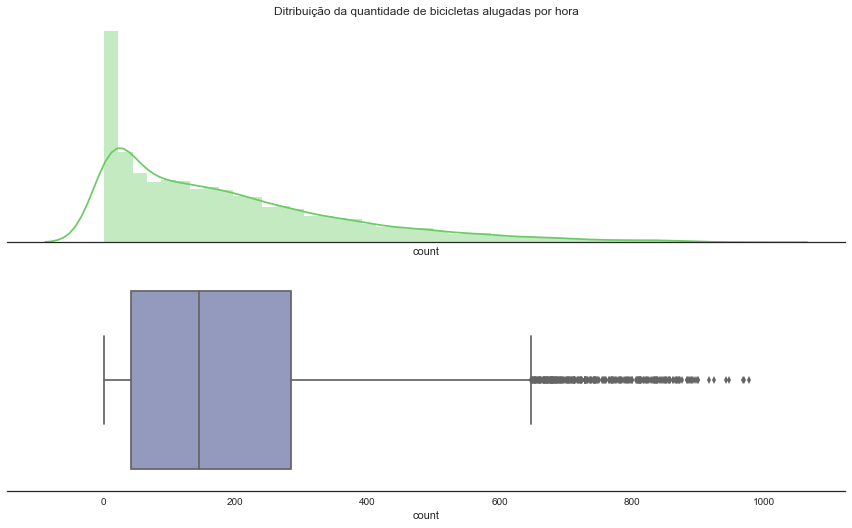

In [5]:
%matplotlib inline
 
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", palette="muted", color_codes=True)

# Set up the matplotlib figure
f, axes = plt.subplots(2,1, figsize=(12, 7.5), sharex=True)
sns.despine(left=True)

# Plot a historgram and kernel density estimate
sns.distplot(dataset['count'],color="g",norm_hist=True,ax=axes[0]).set_title('Ditribuição da quantidade de bicicletas alugadas por hora')

# Plot the orbital period with horizontal boxes
sns.boxplot(x='count', data=dataset,palette="BuPu",ax=axes[1])
plt.setp(axes, yticks=[])
plt.tight_layout()


In [6]:
dataset['count'].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

Inicialmente podemos ver que a variável que representa o número de bicicletas alugadas por hora e dia é bastante volátil. Em média temos 191 bicletas alugadas por hora, mas o desvio padrão é de 181 bicicletas, o que deixa a estimativa da média em um range bastante amplo. A mediana é de 145 bicicletas, um pouco abaixo da média. A distribuição, como podemos ver nos gráficos acima tem a calda da direita bastante alongada, mostrando grande assimetria. Podemos ver que até o pecentil 75 os dados se comportam relaivamente de forma parecida, porém o último percentil é composto por diversos valores discrepantes, sendo que na maior locação registrada obteve-se 977 bicicletas em uso em uma hora.

## 1.2 - Relações da variável alvo

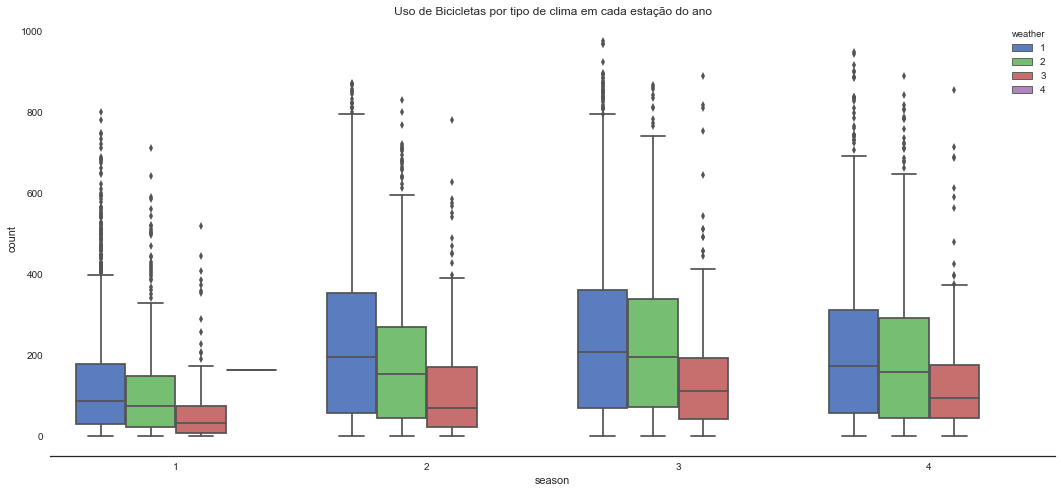

In [7]:
%matplotlib inline
f, axes = plt.subplots(figsize=(18, 8), sharex=True)
sns.boxplot(y="count", x="season",hue="weather", data=dataset).set_title("Uso de Bicicletas por tipo de clima em cada estação do ano")
sns.despine(left=True)

Para Auxiliar na análise:

    season    : 1 = inverno, 2 = primavera, 3 = verão, 4 = outono
    weather   : 1 = Bom, 2 = Névoa/Tempo Fechado, 3 = Chuvoso, 4 = Chuva Forte/Neve
    
Podemos constatar o senso comum pelo gráfico acima. Primavera e verão possuem bons índices de uso, e todos eles pautados pelo tipo de clima do dia e hora em questão. Podemos ver que no inverno, mesmo com tempo bom (caixa azul do label 1),a média de uso não se compara às outras estações. Acredito que a outra variável que está incluída neste processo decisório seja a temperatura, que no inverno, mesmo com tempo bom é baixa e afugenta os usuários.

Além disto, podemos constatar que quando no clima entra a variável chuva, a média de utilização do serviço cai abruptamente; o tamanho das caixas nos ajudam a comprovar essa informação. Finalizando, quando temos clima 4 (4: Chuva forte + "Paletas" de Gelo + Trovoada + Névoa, Neve + Nevoeiro) não temos utilizadores.


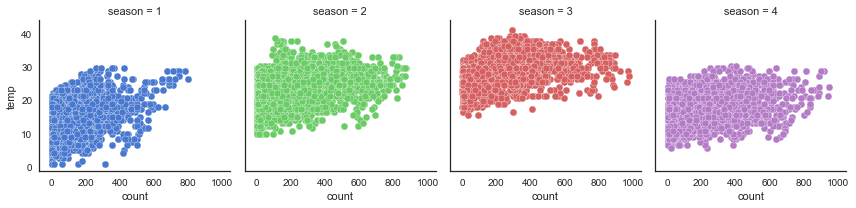

In [8]:
# Uso de bicicletas por nível de temparatura em cada estação do ano
%matplotlib inline
a = sns.FacetGrid(dataset, col="season", hue="season")
a = (a.map(plt.scatter, "count", "temp", edgecolor="w"))

Ao analisar o uso de bicicletas por nível de temparatura em cada estação do ano, podemos observar que realmente as máximas temperaturas no inverno são mais baixas e vemos que a massa de dados se comporta em um formato trinagular, diferentemente das demais estações. Ou seja, quanto mais baixa a temperatura menos usuários. Vemos também que as máximas utilizações das bicicletas são com temperaturas entre médias e altas, numa faixa entre 20º e 30º, e que com calor demais a utilização cai, por exemplo quando a temperatura excede os 35ºC.

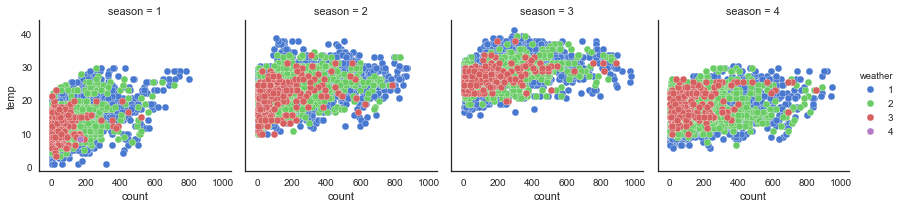

In [9]:
# Uso de bicicletas por nível de temperatura, tipo de clima e em cada estação do ano.
%matplotlib inline
b = sns.FacetGrid(dataset, col="season", hue="weather")
b = (b.map(plt.scatter, "count", "temp", edgecolor="w").add_legend())

Observando o gráfico acim, vemos uma hipótese interessante e que era de se esperar; quando chove o serviço cai muito de rendimento. Independente da estação do ano e temperatura, a utilização nesta etapa é substancialmente menor que em dias normais. A massa de dados vermelha e roxa é substancialmente menor que as de tempo bom (azul e verde). Talvez seja interesante criarmos uma variável, posteriormente, indicando chuva ou não.

Um dos pontos que certamente afetam o uso de bicicletas é a chuva. Podemos verificar se a mesma é um bom balizador de chuva ou não. 

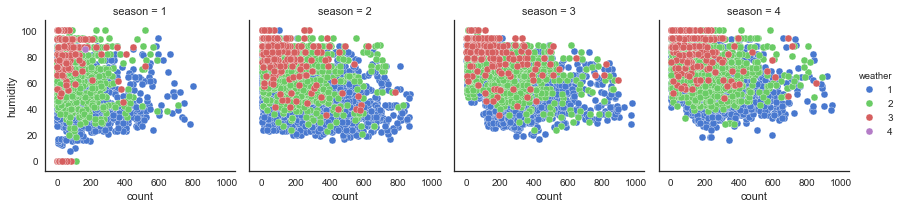

In [10]:
# Uso de bicicletas por nível de umidade, tipo de clima e em cada estação do ano.
%matplotlib inline
c = sns.FacetGrid(dataset, col="season", hue="weather")
c = (c.map(plt.scatter, "count", "humidity", edgecolor="w").add_legend())

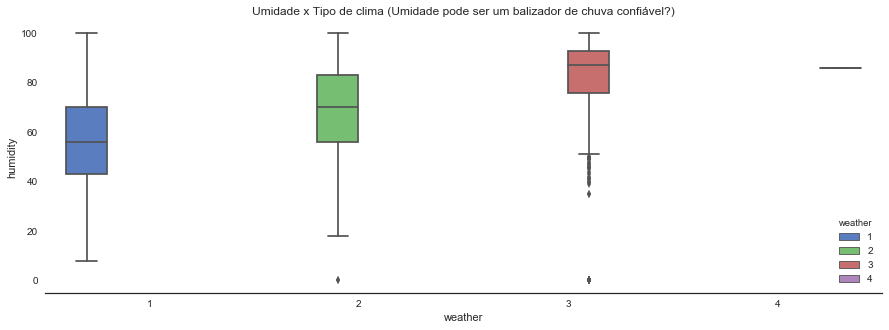

In [11]:
# Umidade x Tipo de clima (Umidade pode ser um balizador de chuva confiável?)
%matplotlib inline
f, axes = plt.subplots(figsize=(15, 5), sharex=True)
sns.boxplot(y="humidity", x="weather",hue="weather", data=dataset).set_title("Umidade x Tipo de clima (Umidade pode ser um balizador de chuva confiável?)")
sns.despine(left=True)

Ao analisar a umidade, especificamente as marginais dos gráficos de dispersão acima, vemos que altos níveis de umidade geram menores níveis de utilização do serviço. Mas a relação com o clima não necessariamente produz um indicador robusto de diminuição abrupta da utilização. Embora o clima 3, esperadamente, tem um nível de umidade maior, boa parte de seus valores não considerados como outliers (e boa parte da caixa também) fazem intercessão com o clima 2, que é um clima de tempo fechado, porém sem chuva, e que portanto não deveria impactar tanto na utlização do serviço. Isso nos complica a usar umidade como um balizador de chuva.

Continuando a analise das varáveis climáticas com o uso de bicicletas, temos a velocidade do vento. Sua relação com o alugel de bicicletas vemos nos gráficos abaixo:

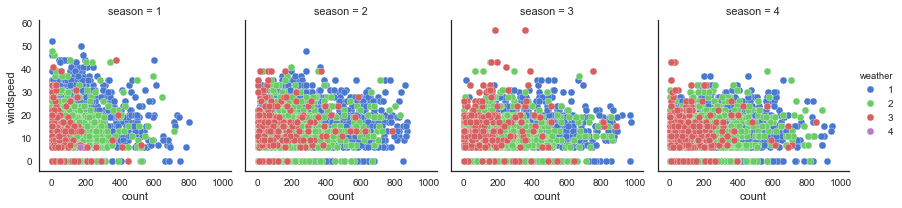

In [12]:
%matplotlib inline
d = sns.FacetGrid(dataset, col="season", hue="weather")
d = (d.map(plt.scatter, "count", "windspeed", edgecolor="w").add_legend())

A velocidade do vento, inicialmente aparenta ser relevante no inverno, onde as temperaturas são mais baixas. Um fato interessante é que no inverno em média temos alugueis com ventos mais velozes do que nos outras estações (um fator natural?). 

Nas demais estações do ano a massa de dados se comporta de maneira relativamente semelhante.

Observamos alguns dados com velocidade de vento 0, um valor estranho, ainda mais se tratando de um valor que sintetiza uma hora completa. Não encontrei em literatura complementar algo que corroborasse estes dados, por isso resolvi removê-los da análise.

In [13]:
dataset = dataset.drop(dataset[dataset.windspeed==0].index)
dataset = dataset.reset_index(drop=True)
dataset.shape

(9573, 12)

Tivemos uma redução de cerca de 1300 linhas de informação, mas isso tende a ser benéfico para o modelo.

Podemos ter uma visão complementar, das relações entre as variáveis, olhando o correlograma abaixo. 

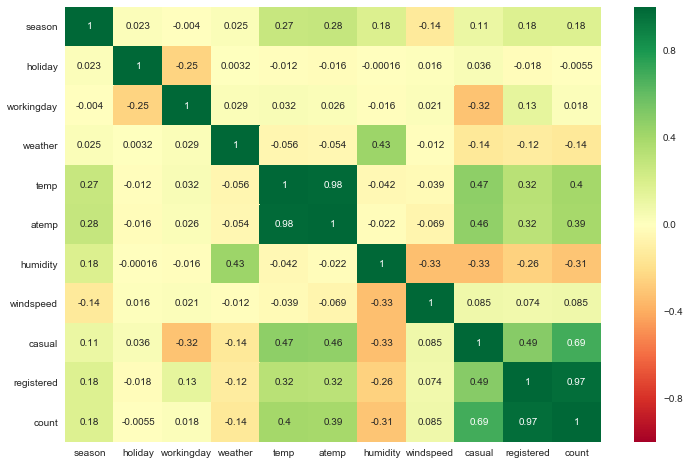

In [14]:
%matplotlib inline
f, ax = plt.subplots(figsize=(12,8))
heatmap = sns.heatmap(dataset.corr(),vmin=-1, vmax=1,annot=True,cmap="RdYlGn")

Vemos que pelo coeficiente de pearson, não temos grandes correlações com a variável alvo. Casual e Registered são variáveis que serão removidas mais a frente, pois são função direta da variável - alvo. Assim o que mais se correlaciona, positivamente, com a variável - alvo é temperatura.

## 1.3 - Pré Processamento

Para continuar nossa análise de relações com a variável alvo, alguns ajustes no banco de dados são necessários para melhorar as variáveis. Desvincular a data da hora, saber qual dia da semana é a data em questão, criar uma variável para chuva, e abir as variáveis categóricas em variáveis dummies, são algumas das mudanças.

In [15]:
#criando colunas de hora, dia, mês e ano.

dataset.datetime = dataset.datetime.apply(pd.to_datetime)
dataset['hour'] = dataset.datetime.apply(lambda x : x.hour)
dataset['day'] = dataset.datetime.apply(lambda x : x.day)
dataset['month'] = dataset.datetime.apply(lambda x : x.month)
dataset['year'] = dataset.datetime.apply(lambda x : x.year)


Inicialmente, vamos excluir as variáveis "datetime", "casual", "registered" e "atemp". "Datetime" é apenas uma chave identificadora, a qual já desmembramos e "Casual" e "Registered", são variáveis que indicam que do total de bicicletas alugadas, x foram de clientes casuais e y de clientes registrados. Estas variáveis não podem ser usadas na modelagem, pois são exatamente as parcelas que somadas, dão o valor exato da variável alvo. Estaríamos roubando, se as usassemos. "Atemp" é altamente correlacionada com "temp", então escolhemos "temp" para continuar a análise.

In [16]:
dataset.drop(['datetime','casual','registered', 'atemp'], axis=1, inplace = True)

Vemos também que temos colunas com dados categóricos. "Season" e "Weather" são categóricas e representam a estação do ano e o clima do local e hora respectivamente. 

Precisamos transformar estas variáveis em variáveis dummy.

Vamos criar uma variável para melhorar o aspecto da chuva, que aparenta ser um fator importante para a realização do serviço, e categorizar as variáveis "Weather" e "Season" para posteriormente transformá-las em dummies.

In [17]:
def chuva(var):
    if var >= 3:
       return 1
    else:
       return 0

def weather(var):
    if var == 1:
        return "Bom"
    elif var == 2:
        return "Névoa/Nublado"
    elif var == 3:
        return "Chuvoso"
    elif var == 4:
        return "Névoa/Chuva Forte"

def season(var):
    if var == 1:
        return "Inverno"
    elif var == 2:
        return "Primavera"
    elif var == 3:
        return "Verão"
    elif var == 4:
        return "Outono"
    
def ano(var):
    if var == 2011:
        return 1
    else:
        return 0

In [18]:
dataset['chuva?'] = dataset['weather'].apply(chuva)
dataset['cat_weather'] = dataset['weather'].apply(weather)
dataset['cat_season'] = dataset['season'].apply(season)
dataset['cat_year'] = dataset['year'].apply(ano)

In [19]:
# Uma maneira mais prática de trasnformar os dados em categóricos
dataset['cat_hour'] = dataset['hour'].astype("object")

In [20]:
def preprocess_features(X):
    ''' Pré-processa os dados e converte as variáveis não numéricas em
        variáveis binárias (0/1). Cada categoria virará uma variável (nova coluna no dataset) '''
    
    # Inicialize nova saída DataFrame
    output = pd.DataFrame(index = X.index)

    # Observe os dados em cada coluna de atributos 
    for col, col_data in X.iteritems():
        
        # Se o tipo de dado for categórico, converta-o para uma variável dummy
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Reúna as colunas revisadas
        output = output.join(col_data)
    
    return output

dataset = preprocess_features(dataset)

In [22]:
dataset.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,count,hour,day,...,cat_hour_14,cat_hour_15,cat_hour_16,cat_hour_17,cat_hour_18,cat_hour_19,cat_hour_20,cat_hour_21,cat_hour_22,cat_hour_23
0,1,0,0,2,9.84,75,6.0032,1,5,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,15.58,76,16.9979,36,10,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,14.76,81,19.0012,56,11,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,17.22,77,19.0012,84,12,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,2,18.86,72,19.9995,94,13,1,...,0,0,0,0,0,0,0,0,0,0


## 1.4 - Relações da variável alvo - Parte 2

Abrimos a segunda parte da análise da variável - alvo com as demais, analisando o uso do serviço por ano.

Text(0.5,1,'Aluguel de biciletas por ano')

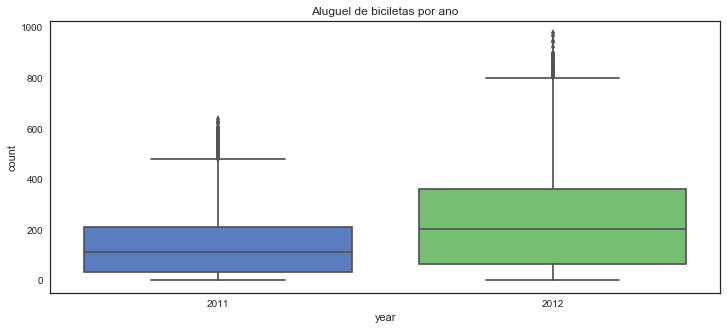

In [23]:
# aluguel x ano
%matplotlib inline
f, axes = plt.subplots(figsize=(12, 5), sharex=True)
sns.boxplot(y="count", x="year", data=dataset).set_title("Aluguel de biciletas por ano")

Podemos ver que houve uma mudança, uma melhora positiva, na utilização do serviço de 2011 para 2012. O serviço se popularizou, e teremos que levar isto para o nosso modelo.

Poderíamos visualizar os dados pela divisão mensal, mas temos a divisão sazonal das estações do ano, que se mostraram úteis e pela parcimônia, ficamos com ela. 

Prosseguindo, podemos ver como os alugueis se comportam por hora.

Text(0.5,1,'Aluguel de biciletas por hora')

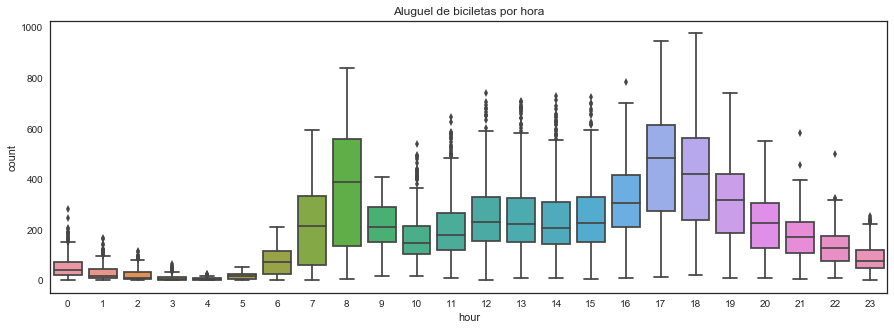

In [24]:
# aluguel x horário
%matplotlib inline
f, axes = plt.subplots(figsize=(15, 5), sharex=True)
sns.boxplot(y="count", x="hour", data=dataset).set_title("Aluguel de biciletas por hora")

Podemos ver que existe uma sazonalidade relativa ao horário, pela manhã, 7 e 8, e pela tarde 16,17, 18 e 19, inicialmente se destacam como horários de pico.

Podemos avaliar a sazonalidade quando chove e quando é dia útil ou não.

Text(0.5,1,'Aluguel de biciletas por hora - E quando chove?')

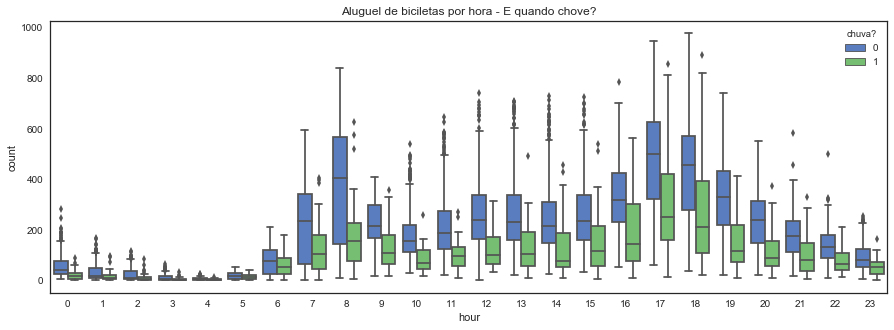

In [25]:
%matplotlib inline
f, axes = plt.subplots(figsize=(15, 5), sharex=True)
sns.boxplot(y="count", x="hour", hue="chuva?",data=dataset).set_title("Aluguel de biciletas por hora - E quando chove?")

Podemos ver a influência do fator chuva reduzindo o uso nos horários de pico. Embora quando chove no horário de saída do trabalho, vemos caixas bem amplas, o que significa que algumas pessoas consideram que voltar pra casa molhadas não é um problema tão sério (ou têm boas capas de chuva =) )

Text(0.5,1,'Alueguel de Bicicletas x Dia util')

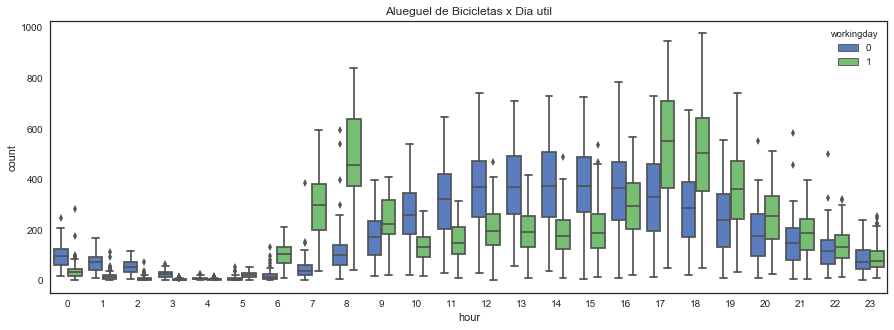

In [26]:
%matplotlib inline
f, axes = plt.subplots(figsize=(15, 5), sharex=True)
sns.boxplot(y="count", x="hour", hue="workingday",data=dataset).set_title("Alueguel de Bicicletas x Dia util")

Quando analisamos as mesmas informações, porém adicionando a segregação de dia útil ou não, vemos que há dois padrões distintos.

    - Dias de semana, com alta demanda de manhã e no fim de tarde/noite. Provavelmente usuários são estudantes e trabalhadores que utilizam o serviço para locomoção.
    
    - Fins de Semana, com alta demanda no fim da manhã até o fim da noite. Uma demanda mais estável, com menos picos. Provavelmente, pessoas que utilizam para passear pela cidade e pequenos deslocamentos, aos fins de semana.

Text(0.5,1,'Aluguel de Bicicletas x Dia util - E quando chove?')

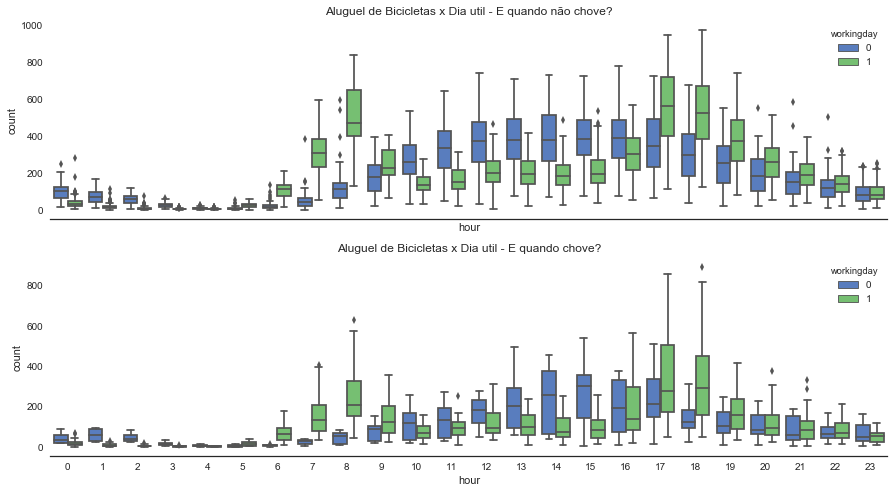

In [27]:
%matplotlib inline
sns.set(style="white", palette="muted", color_codes=True)

# Set up the matplotlib figure
f, axes = plt.subplots(2,1, figsize=(15,8), sharex=True)
sns.despine(left=True)

sns.boxplot(y="count", x="hour", hue="workingday",data=dataset[dataset['chuva?']==0], ax = axes[0]).set_title("Aluguel de Bicicletas x Dia util - E quando não chove?")
sns.boxplot(y="count", x="hour", hue="workingday",data=dataset[dataset['chuva?']==1], ax = axes[1]).set_title("Aluguel de Bicicletas x Dia util - E quando chove?")

Acima, podemos ver o impacto da chuva em ambas as situações, dias de trabalho e fins de semana. Obviamente os índices caem como um todo, porém, nos fins de semana o impacto aparenta ser maior. Em contra partida, ainda temos os picos de horário nos dias de semana, o que indica que algumas pessoas utilizam o serviço mesmo com o tempo ruim.

A partir destas visões podemos criar uma variável que combina "workingday" com as faixas de horário, que seja um balizador de demanda. Se for dia útil e a hora estiver entre, 7 e 8, ou entre 16 a 19, teremos alta demanda, se nao for dia útil e a hora estiver entre 11 e 19, teremos alta demanda, caso contrário baixa demanda. 

In [28]:
# Alta demanda = 1, baixa demanda = 0
def demanda(workingday,hour):
    if workingday == 1 and ((7 <= hour <=8) or (16 <= hour <= 19)):
        return 1
    elif workingday == 0 and (11 <= hour <=19):
        return 1
    else:
        return 0

dataset['demanda'] = dataset.apply(lambda x: demanda(x['workingday'], x['hour']), axis=1)
dataset.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,count,hour,day,...,cat_hour_15,cat_hour_16,cat_hour_17,cat_hour_18,cat_hour_19,cat_hour_20,cat_hour_21,cat_hour_22,cat_hour_23,demanda
0,1,0,0,2,9.84,75,6.0032,1,5,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,15.58,76,16.9979,36,10,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,14.76,81,19.0012,56,11,1,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,1,17.22,77,19.0012,84,12,1,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,2,18.86,72,19.9995,94,13,1,...,0,0,0,0,0,0,0,0,0,1


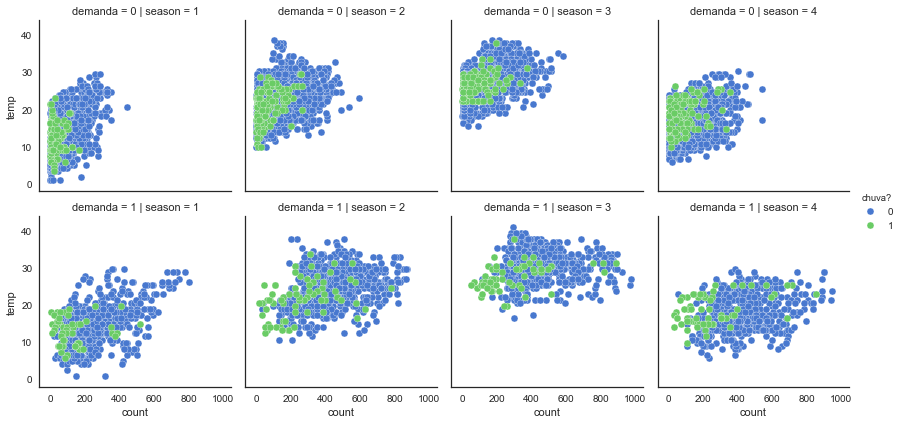

In [29]:
# Uso de bicicletas por nível de umidade, tipo de clima e em cada estação do ano.
%matplotlib inline
d = sns.FacetGrid(dataset, col="season", row="demanda", hue="chuva?")
d = (d.map(plt.scatter, "count", "temp", edgecolor="w").add_legend())

Podemos ver como a variável criada consegue distinguir bem o nível de uso das bicicletas, para todas as estações do ano a variável de demanda consegue separar bem os dados. 

## 1.5 - PCA - Análise de Componentes Principais

Como uma alternativa às variáveis de temperatura, umidade e velocidade do vento(temp, humidity e windspeed), que são variáveis "da natureza" que influenciam o uso, podemos tentar resumí-las em uma única dimensão atratavés da aplicação da técnica de Análise de componentes principais e ver sua relação com a variável alvo.

In [30]:
list(dataset.columns[:])

['season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'humidity',
 'windspeed',
 'count',
 'hour',
 'day',
 'month',
 'year',
 'chuva?',
 'cat_weather_Bom',
 'cat_weather_Chuvoso',
 'cat_weather_Névoa/Chuva Forte',
 'cat_weather_Névoa/Nublado',
 'cat_season_Inverno',
 'cat_season_Outono',
 'cat_season_Primavera',
 'cat_season_Verão',
 'cat_year',
 'cat_hour_0',
 'cat_hour_1',
 'cat_hour_2',
 'cat_hour_3',
 'cat_hour_4',
 'cat_hour_5',
 'cat_hour_6',
 'cat_hour_7',
 'cat_hour_8',
 'cat_hour_9',
 'cat_hour_10',
 'cat_hour_11',
 'cat_hour_12',
 'cat_hour_13',
 'cat_hour_14',
 'cat_hour_15',
 'cat_hour_16',
 'cat_hour_17',
 'cat_hour_18',
 'cat_hour_19',
 'cat_hour_20',
 'cat_hour_21',
 'cat_hour_22',
 'cat_hour_23',
 'demanda']

In [31]:
# Removando as variáveis não interessantes para a técnica. Deixando apenas temp, humidity e windspeed
good_data = dataset.drop(['season', 'holiday', 'workingday', 'weather', 'count', 'hour', 'day', 'month', 
                          'year', 'chuva?', 'cat_weather_Bom', 'cat_weather_Chuvoso', 
                          'cat_weather_Névoa/Chuva Forte', 'cat_weather_Névoa/Nublado', 
                          'cat_season_Inverno', 'cat_season_Outono', 'cat_season_Primavera', 
                          'cat_season_Verão', 'cat_year', 'demanda'], axis=1)


# Vamos identificar o quanto as componentes representam da variabilidade dos dados
from sklearn import decomposition
pca = decomposition.PCA(n_components=3)
pca.fit(good_data)
var = pca.explained_variance_ratio_
variancia_explicada = pd.DataFrame (var, columns = ['variância explicada'])
variancia_explicada

,variância explicada
0,0.778405
1,0.128244
2,0.091366


In [32]:
# Apply PCA by fitting the good data with only two dimensions
pca = decomposition.PCA(1).fit(good_data)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1'])
#reduced_data

In [33]:
reduced_data.shape

(9573, 1)

In [34]:
dataset = pd.concat([dataset, reduced_data], axis=1)

In [35]:
dataset.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,count,hour,day,...,cat_hour_16,cat_hour_17,cat_hour_18,cat_hour_19,cat_hour_20,cat_hour_21,cat_hour_22,cat_hour_23,demanda,Dimension 1
0,1,0,0,2,9.84,75,6.0032,1,5,1,...,0,0,0,0,0,0,0,0,0,-15.205642
1,1,0,0,1,15.58,76,16.9979,36,10,1,...,0,0,0,0,0,0,0,0,0,-14.580143
2,1,0,0,1,14.76,81,19.0012,56,11,1,...,0,0,0,0,0,0,0,0,1,-19.272370
3,1,0,0,1,17.22,77,19.0012,84,12,1,...,0,0,0,0,0,0,0,0,1,-15.264274
4,1,0,0,2,18.86,72,19.9995,94,13,1,...,0,0,0,0,0,0,0,0,1,-10.144395


C:\Users\Thiago\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Thiago\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


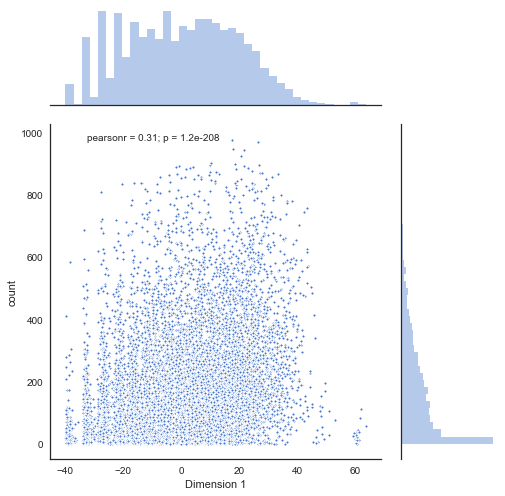

In [36]:
sns.jointplot(x='Dimension 1', y='count', data=dataset,size=7, s=10, ratio=3, edgecolor="w", linewidth=1)

Vemos que a Dimensão 1 explica 77% da variabilidade total das variáveis o que de início é promissor. Porém quando vemos a relação da variável-alvo com a dimensão, temos uma correlação relativamente baixa e talvez ela não seja melhor pra representar as condições climáticas, nos modelos, que as próprias variáveis originais.

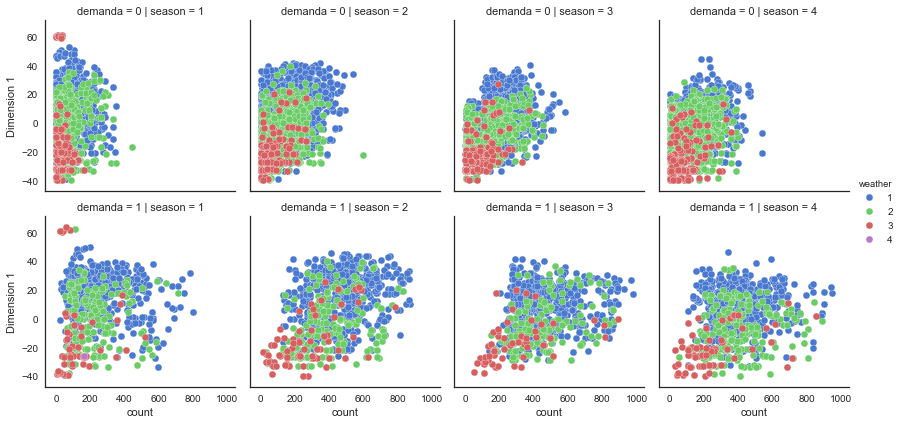

In [37]:
# Uso de bicicletas por nível de umidade, tipo de clima e em cada estação do ano.
%matplotlib inline
d = sns.FacetGrid(dataset, col="season", row="demanda", hue="weather")
d = (d.map(plt.scatter, "count", "Dimension 1", edgecolor="w").add_legend())

## 1.6 Removendo Outliers

Após termos noção do comportamento das variáveis explicativas com a variável resposta, podemos remover alguns outliers, para melhorar a etapa de modelagem. Vimos que a variável alvo 'count', é bastante assimétrica a direita e possui vários pontos discrepantes, representativos de horários com um número bastante elevado de bicicletas. 

Nesta sessão iremos identificá-los e removê-los do dataset.

In [38]:
dataset.shape

(9573, 48)

In [39]:
# Calculo Q1 (25º percentil dos dados) para o atributo dado
Q1 = np.percentile(dataset['count'],25)
    
# Calculo Q3 (75º percentil dos dados) para o atributo dado
Q3 = np.percentile(dataset['count'],75)
    
# Utilizar a amplitude interquartil para calcular o passo do discrepante (1,5 vezes a variação interquartil)
step = 1.5*(Q3-Q1)

# Mostre os discrepantes
#print ("Data points considered outliers for the feature '{}':",'feature')
outlier = dataset[~((dataset['count'] >= Q1 - step) & (dataset['count'] <= Q3 + step))]
outlier.shape

(268, 48)

In [40]:
dataset = dataset.drop(outlier.index).reset_index(drop = True)

In [41]:
dataset.shape

(9305, 48)

Finalizamos a fase de análise e pré processamento com 9305 linhas de informação, o que é suficiente para realizarmos a modelagem e a divisão entre treino e teste com fidedignidade.

# 2 - Modelagem:

Iremos aplicar alguns algoritmos e avaliar a aderência aos dados.

Iremos testar a aderência dos dados de teste aos seguintes modelos:
    
       - Regressão Linear
       - Árvore de Decisão
       - Randon Forest
       - Gradient Boosting Regressor

## 2.1 - Criação das métricas de desempenho

Em relação a avaliação dos modelos iremos mensurá-los através do R². Adicionalmente iremos olhar  MAPE, porém a definição será em cima do R².

Como medida de comparação com modelos provenientes das competições do kaggle, iremos adotar o RMSLE (root mean squared logarithimic error).

In [42]:
""" Calcular e retornar a pontuação de desempenho entre 
        valores reais e estimados baseado na métrica escolhida. """

def r2(y_true, y_predict):
        
    from sklearn.metrics import r2_score
        
    # Calcular a pontuação de desempenho entre 'y_true' e 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Devolver a pontuação
    return score

def MAPE(y_true, y_pred): 
    
    import numpy as np 
       
    # Calcular a pontuação de desempenho entre 'y_true' e 'y_predict'
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Devolver a pontuação
    return MAPE


def rmsle(y_pred, y_test) : 
    import math
    assert len(y_test) == len(y_pred)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_test))**2))

scoring_function_RMSLE = make_scorer(rmsle)

In [43]:
list(dataset.columns[:])

['season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'humidity',
 'windspeed',
 'count',
 'hour',
 'day',
 'month',
 'year',
 'chuva?',
 'cat_weather_Bom',
 'cat_weather_Chuvoso',
 'cat_weather_Névoa/Chuva Forte',
 'cat_weather_Névoa/Nublado',
 'cat_season_Inverno',
 'cat_season_Outono',
 'cat_season_Primavera',
 'cat_season_Verão',
 'cat_year',
 'cat_hour_0',
 'cat_hour_1',
 'cat_hour_2',
 'cat_hour_3',
 'cat_hour_4',
 'cat_hour_5',
 'cat_hour_6',
 'cat_hour_7',
 'cat_hour_8',
 'cat_hour_9',
 'cat_hour_10',
 'cat_hour_11',
 'cat_hour_12',
 'cat_hour_13',
 'cat_hour_14',
 'cat_hour_15',
 'cat_hour_16',
 'cat_hour_17',
 'cat_hour_18',
 'cat_hour_19',
 'cat_hour_20',
 'cat_hour_21',
 'cat_hour_22',
 'cat_hour_23',
 'demanda',
 'Dimension 1']

## 2.2 Modelo Linear

Avaliaremos a performance do modelo de regressão linear múltipla aos dados

#### Standart

Inicialmente iremos avaliar o modelo Linear com as variáveis padrão do banco de dados e sem as variáveis criadas/transformadas. Este será noso modelo de Benchmark. O modelo mais simples, assim poderemos comparar as evoluções que criarei com estes resultados.

In [291]:
# Definição das variáveis e divisão entre teste e treinamento.
y = dataset['count'] #Variável resposta
X = dataset.drop(['season', 'weather', 'count', 'hour', 'day', 'month', 'year', 
                  "chuva?", "demanda", "Dimension 1"], axis=1) #Variáveis a serem removidas do dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


#Processo de modelagem
reg_RL = linear_model.LinearRegression() #criando o objeto regressor.
reg_RL.fit (X_train,y_train) #ajustando o modelo
beta_train = reg_RL.coef_ #Obtendo as estimativas dos Betas

predict = reg_RL.predict (X_test) #Utilizando os dados de teste para prever os resultados dos mesmos

R2_RL = r2_score(y_test, predict) #Cálculo do R² para os dado de teste
MAPE_RL = MAPE(y_test, predict) #Cálculo do MAPE para os dados teste
rmsle_RL = rmsle(y_test, predict) #Cálculo do RMSLE para os dados teste
scoring_function_RMSLE = make_scorer(rmsle)

print ("O coeficiente r² do conjunto teste é:", R2_RL)
print ("O erro absoluto percentual médio do conjunto teste é (MAPE):", MAPE_RL)
print ("O RMSLE do conjunto teste é:", rmsle_RL)


cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
cv_scores_RL = cross_val_score(reg_RL, X_test, y_test, cv=cv,scoring = 'r2')
cv_scores_RL_RMSLE = cross_val_score(reg_RL, X_test, y_test, cv=cv,scoring = scoring_function_RMSLE)


print ("O r² obtido através de cross validation score é:", np.mean(cv_scores_RL))
print ("O RMSLE obtido através de cross validation score é:", np.mean(cv_scores_RL_RMSLE))

O coeficiente r² do conjunto teste é: 0.6716676234199547
O erro absoluto percentual médio do conjunto teste é (MAPE): 263.11147628339506
O RMSLE do conjunto teste é: 0.7948126585316235
O r² obtido através de cross validation score é: 0.6718031362601374
O RMSLE obtido através de cross validation score é: 0.8355652799563554


C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p
C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p
C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p
C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p
C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p
C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p


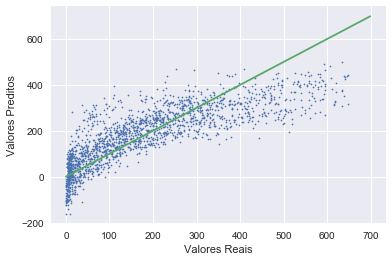

In [292]:
#visualize results
sns.set(style="darkgrid")
plt.plot(y_test, predict,linestyle='', marker='o', markersize=1.7)
plt.xlabel("Valores Reais")
plt.ylabel("Valores Preditos")
a=0
b=700
c = range(a,b)
plt.plot(c,c)
plt.show()

O Scikit learn, infelizmente não oferece, recursos de seleção de variáveis, tais como step wise. Assim utilizaros o artifícios do método F-Regression, para nos ajudar a entender a significância das variáveis.

In [293]:
from sklearn.feature_selection import f_regression
feature_importance_RL = f_regression(X_train,y_train)
cabeçalho = list(X.columns)
FI_RL = pd.DataFrame({'1 - Variáveis':cabeçalho, '2 - Betas': beta_train, '3 - teste F': feature_importance_RL[0], '4 - p- valor': feature_importance_RL[1]})
FI_RL = FI_RL.sort_values(by=['4 - p- valor'],ascending=False)

intercept = reg_RL.intercept_
print("O coeficiente B0, ou intercepto é: ", intercept)
FI_RL

O coeficiente B0, ou intercepto é:  24340802347334.883


,1 - Variáveis,2 - Betas,3 - teste F,4 - p- valor
7,cat_weather_Névoa/Chuva Forte,-8.551246e+12,0.009624,9.218541e-01
35,cat_hour_21,-5.081297e+11,0.342377,5.584783e-01
0,holiday,-1.019709e+01,0.526604,4.680610e-01
24,cat_hour_10,-5.081297e+11,2.032755,1.539833e-01
1,workingday,-3.038994e+00,2.710873,9.970868e-02
21,cat_hour_7,-5.081297e+11,12.650341,3.778321e-04
10,cat_season_Outono,-1.528143e+13,13.264794,2.722752e-04
25,cat_hour_11,-5.081297e+11,16.369557,5.264278e-05
8,cat_weather_Névoa/Nublado,-8.551246e+12,19.964326,8.006745e-06
23,cat_hour_9,-5.081297e+11,26.692473,2.447449e-07


#### Com a inserção da variável criada "demanda"

Agora incluiremos a variável criada "Demanda", que relaciona o horário com o fator dia útil/ dia não útil.

In [294]:
# Definição das variáveis e divisão entre teste e treinamento.
y = dataset['count'] #Variável resposta
X = dataset.drop(['season','holiday', 'weather', 'count', 'hour', 'day', 'month', 'year', 
                  'chuva?','Dimension 1'], axis=1) #Variáveis a serem removidas do dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


#Processo de modelagem
reg_RL2 = linear_model.LinearRegression() #criando o objeto regressor.
reg_RL2.fit (X_train,y_train) #ajustando o modelo
beta_train = reg_RL2.coef_ #Obtendo as estimativas dos Betas

predict_RL2 = reg_RL2.predict (X_test) #Utilizando os dados de teste para prever os resultados dos mesmos

R2_RL2 = r2_score(y_test, predict_RL2) #Cálculo do R² para os dado de teste
MAPE_RL2 = MAPE(y_test, predict_RL2) #Cálculo do MAPE para os dados teste
rmsle_RL2 = rmsle(y_test, predict_RL2) #Cálculo do RMSLE para os dados teste

print ("O coeficiente r² do conjunto teste é:", R2_RL2)
print ("O erro absoluto percentual médio do conjunto teste é (MAPE):", MAPE_RL2)
print ("O RMSLE do conjunto teste é:", rmsle_RL2)


cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
cv_scores_RL2 = cross_val_score(reg_RL2, X_test, y_test, cv=cv,scoring = 'r2')
cv_scores_RMSLE_RL2 = cross_val_score(reg_RL2, X_test, y_test, cv=cv,scoring = scoring_function_RMSLE)

print ("O r² obtido através de cross validation score é:", np.mean(cv_scores_RL2))
print ("O RMSLE obtido através de cross validation score é:", np.mean(cv_scores_RMSLE_RL2))


O coeficiente r² do conjunto teste é: 0.7761882088006105
O erro absoluto percentual médio do conjunto teste é (MAPE): 257.5572265928565
O RMSLE do conjunto teste é: 0.7959749954585793
O r² obtido através de cross validation score é: 0.7739115294955194
O RMSLE obtido através de cross validation score é: 0.8071327229542146


C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p
C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p
C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p
C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p
C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p
C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p


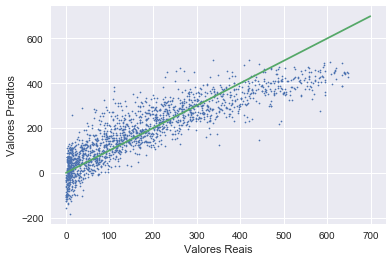

In [295]:
#visualize results
plt.plot(y_test, predict_RL2,linestyle='', marker='o', markersize=1.7)
plt.xlabel("Valores Reais")
plt.ylabel("Valores Preditos")
a=0
b=700
c = range(a,b)
plt.plot(c,c)
plt.show()

Vemos aqui que a variável trouxe um ganho signifiativo para o R² do modelo. Saímos de um R² de 0,67 no conjunto teste para 0,774 no mesmo conjunto. A variável Demanda trouxe significância interessante para o modelo.

#### Com a inserção das variáveis criadas "chuva" e "demanda".

A inserção da variável chuva impacta em retirar do modelo as variáveis de clima (Bom, Nublado, Chuva leve/Névoa, Neve/Chuva Forte). Ela resume os dados em chuva e não chuva. A variável "demanda" continuará no modelo.

In [296]:
# Definição das variáveis e divisão entre teste e treinamento.
y = dataset['count'] #Variável resposta
X = dataset.drop(['season', 'holiday', 'weather', 'count', 'hour', 'day', 'month', 'year',
                  'cat_weather_Bom', 'cat_weather_Chuvoso',  'cat_weather_Névoa/Chuva Forte', 
                  'cat_weather_Névoa/Nublado','Dimension 1'], axis=1) #Variáveis a serem removidas do dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


#Processo de modelagem
reg_RL3 = linear_model.LinearRegression() #criando o objeto regressor.
reg_RL3.fit (X_train,y_train) #ajustando o modelo
beta_train = reg_RL3.coef_ #Obtendo as estimativas dos Betas

predict_RL3 = reg_RL3.predict (X_test) #Utilizando os dados de teste para prever os resultados dos mesmos

R2_RL3 = r2_score(y_test, predict_RL3) #Cálculo do R² para os dado de teste
MAPE_RL3 = MAPE(y_test, predict_RL3) #Cálculo do MAPE para os dados teste
rmsle_RL3 = rmsle(y_test, predict_RL3) #Cálculo do RMSLE para os dados teste

print ("O coeficiente r² do conjunto teste é:", R2_RL3)
print ("O erro absoluto percentual médio do conjunto teste é (MAPE):", MAPE_RL3)
print ("O RMSLE do conjunto teste é:", rmsle_RL3)

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
cv_scores_RL3 = cross_val_score(reg_RL3, X_test, y_test, cv=cv,scoring = 'r2')
cv_scores_RMSLE_RL3 = cross_val_score(reg_RL3, X_test, y_test, cv=cv,scoring = scoring_function_RMSLE)

print ("O r² obtido através de cross validation score é:", np.mean(cv_scores_RL3))
print ("O RMSLE obtido através de cross validation score é:", np.mean(cv_scores_RMSLE_RL3))

O coeficiente r² do conjunto teste é: 0.7768492112081115
O erro absoluto percentual médio do conjunto teste é (MAPE): 255.99106719324408
O RMSLE do conjunto teste é: 0.8075025232679842
O r² obtido através de cross validation score é: 0.7734184804467178
O RMSLE obtido através de cross validation score é: 0.7767723298856483


C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p
C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p
C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p
C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p
C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p
C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p


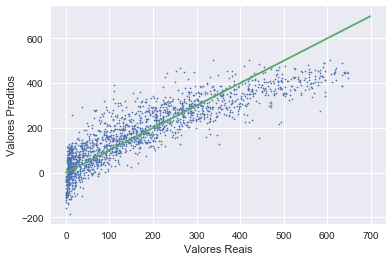

In [297]:
#visualize results
plt.plot(y_test, predict_RL3, linestyle='', marker='o', markersize=1.7)
plt.xlabel("Valores Reais")
plt.ylabel("Valores Preditos")
a=0
b=700
c = range(a,b)
plt.plot(c,c)
plt.show()

O resultado foi praticamente o mesmo da variante do modelo linear anterior. O R² do conjunto teste foi de 0,773.

#### Com a inserção das variáveis criadas "chuva", "demanda" e a dimensão criada para representar a condição climatica.

Agora introduziremos a dimensão criada através da PCA, que tenta representar a condição climática do horário em uma única vertente. Como consequência de sua introdução iremos remover, "temp", "humidity" e "windspeed".

In [298]:
# Definição das variáveis e divisão entre teste e treinamento.
y = dataset['count'] #Variável resposta
X = dataset.drop(['season', 'holiday', 'weather', 'count', 'hour', 'day', 'month', 'year',
                  'temp', 'humidity', 'windspeed',
                  'cat_weather_Bom', 'cat_weather_Chuvoso',  'cat_weather_Névoa/Chuva Forte', 
                  'cat_weather_Névoa/Nublado'], axis=1) #Variáveis a serem removidas do dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


#Processo de modelagem
reg_RL4 = linear_model.LinearRegression() #criando o objeto regressor.
reg_RL4.fit (X_train,y_train) #ajustando o modelo
beta_train = reg_RL4.coef_ #Obtendo as estimativas dos Betas

predict_RL4 = reg_RL4.predict (X_test) #Utilizando os dados de teste para prever os resultados dos mesmos

R2_RL4 = r2_score(y_test, predict_RL4) #Cálculo do R² para os dado de teste
MAPE_RL4 = MAPE(y_test, predict_RL4) #Cálculo do MAPE para os dados teste
rmsle_RL4 = rmsle(y_test, predict_RL4) #Cálculo do RMSLE para os dados teste

print ("O coeficiente r² do conjunto teste é:", R2_RL4)
print ("O erro absoluto percentual médio do conjunto teste é (MAPE):", MAPE_RL4)
print ("O RMSLE do conjunto teste é:", rmsle_RL4)

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
cv_scores_RL4 = cross_val_score(reg_RL4, X_test, y_test, cv=cv,scoring = 'r2')
cv_scores_RMSLE_RL4 = cross_val_score(reg_RL4, X_test, y_test, cv=cv,scoring = scoring_function_RMSLE)

print ("O r² obtido através de cross validation score é:", np.mean(cv_scores_RL4))
print ("O RMSLE obtido através de cross validation score é:", np.mean(cv_scores_RMSLE_RL4))

O coeficiente r² do conjunto teste é: 0.7505707098866189
O erro absoluto percentual médio do conjunto teste é (MAPE): 257.0192875254432
O RMSLE do conjunto teste é: 0.8155480790332441
O r² obtido através de cross validation score é: 0.7473098035119863
O RMSLE obtido através de cross validation score é: 0.8303480954375454


C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p
C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p
C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p
C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p
C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p
C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p


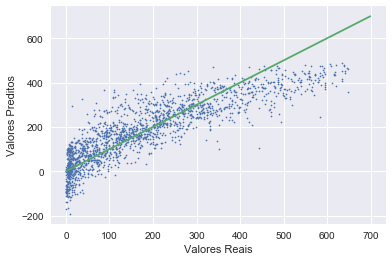

In [299]:
#visualize results
plt.plot(y_test, predict_RL4, linestyle='', marker='o', markersize=1.7)
plt.xlabel("Valores Reais")
plt.ylabel("Valores Preditos")
a=0
b=700
c = range(a,b)
plt.plot(c,c)
plt.show()

O resultado decresce em relação às variantes anteriores, o que indica, infelizmente, que a dimensão criada simplifica demais as nuances das três variáveis omitidas e o modelo perde capacidade de explicação.

Assim, nosso melhor modelo linear, por uma diferença mínima de performance para o "2º colocado" é o "Com a inserção da variável criada Demanda". 

## 2.2 Árvore de Decisão

Iremos aqui avaliar se o algortimo da árvore de decisão consegue um melhor ajuste do que o de Regressão Linear. Posteriormente tentaremos o ajuste do modelo, principalmente da produndidade máxima, através de GridSearch.

In [310]:
# Definição das variáveis e divisão entre teste e treinamento.
y = dataset['count'] #Variável resposta
X = dataset.drop(['season','holiday', 'weather', 'count', 'hour', 'day', 'month', 'year', 
                  'chuva?','Dimension 1'], axis=1) #Variáveis a serem removidas do dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


# Criar um árvore de decisão regressora e ajustá-la ao conjunto de treinamento
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

reg_DT = DecisionTreeRegressor()
reg_DT.fit(X_train, y_train)
prev_DT = reg_DT.predict(X_test)

# Reportar a pontuação da previsão utilizando o conjunto de teste

R2_DT = r2(y_test,prev_DT)
MAPE_DT = MAPE(y_test,prev_DT)
rmsle_DT = rmsle(y_test, prev_DT) #Cálculo do RMSLE para os dados teste

print ("O coeficiente de determinação, R², do modelo é {:.3f}.".format(R2_DT))
print ("O erro absoluto percentual médio do conjunto teste é (MAPE):", MAPE_DT)
print ("O RMSLE do conjunto teste é:", rmsle_DT)

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
cv_scores_DT = cross_val_score(reg_DT, X_test, y_test, cv=cv,scoring = 'r2')
cv_scores_RMSLE_DT = cross_val_score(reg_DT, X_test, y_test, cv=cv,scoring = scoring_function_RMSLE)


print ("O r² obtido através de cross validation score é:", np.mean(cv_scores_DT))
print ("O RMSLE obtido através de cross validation score é:", np.mean(cv_scores_RMSLE_DT))

O coeficiente de determinação, R², do modelo é 0.836.
O erro absoluto percentual médio do conjunto teste é (MAPE): 53.12910601494247
O RMSLE do conjunto teste é: 0.5421397045123677
O r² obtido através de cross validation score é: 0.7253459251825782
O RMSLE obtido através de cross validation score é: 0.6671881719810898


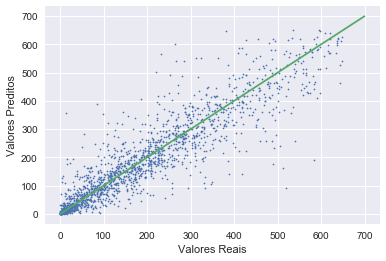

In [311]:
#visualize results
plt.plot(y_test, prev_DT,linestyle='', marker='o', markersize=1.7)
plt.xlabel("Valores Reais")
plt.ylabel("Valores Preditos")
a=0
b=700
c = range(a,b)
plt.plot(c,c)
plt.show()


In [313]:
feature_importance_DT = reg_DT.feature_importances_
cabeçalho = list(X.columns)
FI_DT = pd.DataFrame({'1 - Variáveis':cabeçalho, '2 - Importância': feature_importance_DT})
FI_DT = FI_DT.sort_values(by=['2 - Importância'],ascending=False)
FI_DT

,1 - Variáveis,2 - Importância
37,demanda,0.415842
1,temp,0.101154
2,humidity,0.082776
12,cat_year,0.077578
8,cat_season_Inverno,0.061609
0,workingday,0.028860
22,cat_hour_9,0.024386
33,cat_hour_20,0.021810
5,cat_weather_Chuvoso,0.018431
3,windspeed,0.017888


O modelo padrão da árvore de decisão consegue superar o desempenho do melhor modelo linear. Pelo gráfico dos resíduos, podemos ver que os dados, apesar de seguirem a tendência da linha ótima, estão muito espalhados, o que prejudica o R², ainda assim, temos um R² de 0,72.

Interessante observar que novamente a variável demanda aparece com alto grau de importância parao modelo.

### 2.2.1 Grid Search para Otimizar a Árvore

A ideia aqui é utilizar de um algoritmo iterativo pra procurar qual o melhor ajuste para a árvore de decisão. A avaliação é na profundidade máxima da árvore, ou seja, quantas "perguntas" o algoritmo faz para dividir os dados. Ao encontrar este valor Ideal, esperamos que a árvore generalize melhor os dados que não conhece e produza um resultado superior ao visto anteriormente.

In [317]:
def fit_model(X, y):
    """ Desempenhar busca em matriz sobre o parâmetro the 'max_depth' para uma 
        árvore de decisão de regressão treinada nos dados de entrada [X, y]. """
    
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.metrics import make_scorer
    from sklearn.grid_search import GridSearchCV
    from sklearn.cross_validation import ShuffleSplit
    
    # Gerar conjuntos de validação-cruzada para o treinamento de dados
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 350, test_size = 0.20, random_state = 42)

    # Gerar uma árvore de decisão de regressão de objeto
    regressor = DecisionTreeRegressor()

    # Gerar um dicionário para o parâmetro 'max_depth' com um alcance de 1 a 10
    params = [{'max_depth':list(range(3,37,1))}]
    

    # Transformar 'performance_metric' em uma função de pontuação utilizando 'make_scorer' 
    scoring_fnc = make_scorer(r2)

    # Gerar o objeto de busca em matriz
    
    grid = GridSearchCV(regressor, params, scoring = scoring_fnc, cv = cv_sets)

    # Ajustar o objeto de busca em matriz com os dados para calcular o modelo ótimo
    grid = grid.fit(X, y)

    # Devolver o modelo ótimo depois de realizar o ajuste dos dados
    return grid.best_estimator_

In [318]:
# Ajustar os dados de treinamento para o modelo utilizando busca em matriz
reg_DT2 = fit_model(X_train, y_train)

# Produzir valores para 'max_depth'
print ("O parâmetro 'max_depth' é",(reg_DT2.get_params()['max_depth']))
reg_DT2.get_params()

O parâmetro 'max_depth' é 18


{'criterion': 'mse',
 'max_depth': 18,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

In [319]:
prev_DT2 = reg_DT2.predict(X_test)

# Reportar a pontuação da previsão utilizando o conjunto de teste

score_DT2 = r2(y_test,prev_DT2)
print ("O coeficiente de determinação, R², do modelo é {:.3f}.".format(score_DT2))

MAPE_DT2 = MAPE(y_test,prev_DT2)
print ("O erro absoluto percentual médio do conjunto teste é (MAPE):", MAPE_DT2)

RMSLE_DT2 = rmsle(y_test,prev_DT2)
print ("O RMSLE do conjunto teste é:", MAPE_DT2)

O coeficiente de determinação, R², do modelo é 0.841.
O erro absoluto percentual médio do conjunto teste é (MAPE): 51.78671772652182
O RMSLE do conjunto teste é: 51.78671772652182


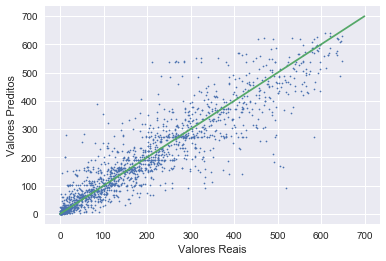

In [320]:
#visualize results
plt.plot(y_test, prev_DT2,linestyle='', marker='o', markersize=1.7)
plt.xlabel("Valores Reais")
plt.ylabel("Valores Preditos")
a=0
b=700
c = range(a,b)
plt.plot(c,c)
plt.show()

In [321]:
feature_importance_DT2 = reg_DT2.feature_importances_
cabeçalho = list(X.columns)
FI_DT2 = pd.DataFrame({'1 - Variáveis':cabeçalho, '2 - Importância': feature_importance_DT2})
FI_DT2 = FI_DT2.sort_values(by=['2 - Importância'],ascending=False)
FI_DT2

,1 - Variáveis,2 - Importância
37,demanda,0.426852
1,temp,0.100065
12,cat_year,0.079630
2,humidity,0.079517
8,cat_season_Inverno,0.062973
0,workingday,0.028575
22,cat_hour_9,0.024975
33,cat_hour_20,0.022295
5,cat_weather_Chuvoso,0.018151
21,cat_hour_8,0.015940


E de fato, o modelo não só melhora, como se torna a melhor estimativa até aqui, com R² de 0,84, um incremento de quase 0,2 para o resultado do modelo de benchmark. O gráfico de Resíduos típico de uma Árvoe de Decisão (vemos as escadas), está mais coeso e unido. 

## 2.3 Random Forest (Evoluindo as árvores de decisão)

tentaremos aqui um método de aprendizado conjunto, as florestas aleatórias.

In [46]:
# Definição das variáveis e divisão entre teste e treinamento.
y = dataset['count'] #Variável resposta
X = dataset.drop(['season','holiday', 'weather', 'count', 'hour', 'day', 
                  'month', 'year','chuva?','Dimension 1'], axis=1) #Variáveis a serem removidas do dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


# vamos ver como a gente se sai usando Floresta Aleatória
from sklearn.ensemble import RandomForestRegressor
# n_estimator é o número de árvores na floresta
rfr = RandomForestRegressor(n_estimators=1000)
# ajustando o modelo
rfr.fit(X_train, y_train)
#realizando as previsões, em cima da base de teste
prev_RF = rfr.predict(X_test)

# medindo o ajuste do modelo, comparando as previsões com a saída de teste previamente segregada 
score_RF = r2(y_test,prev_RF)
MAPE_RF = MAPE(y_test,prev_RF)
RMSLE_RF = rmsle(y_test,prev_RF)

print ("O coeficiente de determinação, R², do modelo é:", score_RF)
print ("O erro absoluto percentual médio do conjunto teste é (MAPE):", MAPE_RF)
print ("O RMSLE do conjunto teste é (MAPE):", RMSLE_RF)

# validando o resultado através de cross validation
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
cv_scores_RF = cross_val_score(rfr, X_test, y_test, cv=cv,scoring = 'r2')
cv_scores_RMSLE_RF = cross_val_score(rfr, X_test, y_test, cv=cv,scoring = scoring_function_RMSLE)

print ("O r² obtido através de cross validation score é:", np.mean(cv_scores_RF))
print ("O RMSLE obtido através de cross validation score é:", np.mean(cv_scores_RMSLE_RF))

O coeficiente de determinação, R², do modelo é: 0.9099945900734251
O erro absoluto percentual médio do conjunto teste é (MAPE): 46.05208554956934
O RMSLE do conjunto teste é (MAPE): 0.43492299600447293
O r² obtido através de cross validation score é: 0.8512361411739567
O RMSLE obtido através de cross validation score é: 0.6405794311221821


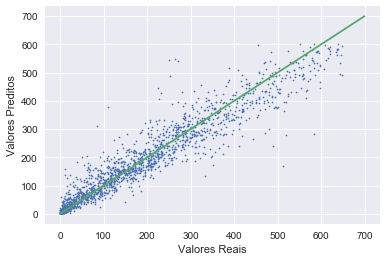

In [323]:
#visualize results
plt.plot(y_test, prev_RF, linestyle='', marker='o', markersize=1.7)
plt.xlabel("Valores Reais")
plt.ylabel("Valores Preditos")
a=0
b=700
c = range(a,b)
plt.plot(c,c)
plt.show()

In [324]:
feature_importance_RF = rfr.feature_importances_
cabeçalho = list(X.columns)
FI_RF = pd.DataFrame({'1 - Variáveis':cabeçalho, '2 - Importância': feature_importance_RF})
FI_RF = FI_RF.sort_values(by=['2 - Importância'],ascending=False)
FI_RF

,1 - Variáveis,2 - Importância
37,demanda,0.415176
1,temp,0.122564
2,humidity,0.082395
12,cat_year,0.074071
8,cat_season_Inverno,0.045450
0,workingday,0.024851
22,cat_hour_9,0.022814
33,cat_hour_20,0.021863
3,windspeed,0.019492
21,cat_hour_8,0.016833


### 2.3.1 Grid Search para Otimizar o Random Forest

In [332]:
def fit_model_RF(X, y):
    
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import make_scorer
    from sklearn.grid_search import GridSearchCV
    from sklearn.cross_validation import ShuffleSplit
    
    # Gerar conjuntos de validação-cruzada para o treinamento de dados
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 42)

    # Gerar Random Forest de regressão de objeto
    regressor = RandomForestRegressor()

    # Gerar um dicionário para os parâmetros do algoritmo
    params = [{'n_estimators' :[350],
              'max_depth':list(range(3,33,3)),
              'max_features' : ['auto','sqrt' , 'log2']}] 
                    
    # Transformar 'performance_metric' em uma função de pontuação utilizando 'make_scorer' 
    scoring_fnc = make_scorer(r2)

    # Gerar o objeto de busca em matriz
    
    grid = GridSearchCV(regressor, params, scoring = scoring_fnc, cv = cv_sets)

    # Ajustar o objeto de busca em matriz com os dados para calcular o modelo ótimo
    grid = grid.fit(X, y)

    # Devolver o modelo ótimo depois de realizar o ajuste dos dados
    return grid.best_estimator_

In [333]:
# Ajustar os dados de treinamento para o modelo utilizando busca em matriz
reg_RF2 = fit_model_RF(X_train, y_train)

# Produzir valores para 'max_depth'
print ("O parâmetro 'max_depth' é",(reg_RF2.get_params()['max_depth']))
reg_RF2.get_params()

O parâmetro 'max_depth' é 30


{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 30,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 350,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [334]:
prev_RF2 = reg_RF2.predict(X_test)

# Reportar a pontuação da previsão utilizando o conjunto de teste

score_RF2 = r2(y_test,prev_RF2)
print ("O coeficiente de determinação, R², do modelo é {:.3f}.".format(score_RF2))

MAPE_RF2 = MAPE(y_test,prev_RF2)
print ("O erro absoluto percentual médio do conjunto teste é (MAPE):", MAPE_RF2)

RMSLE_RF2 = rmsle(y_test,prev_RF2)
print ("O RMSLE do conjunto teste é:", RMSLE_RF2)

O coeficiente de determinação, R², do modelo é 0.911.
O erro absoluto percentual médio do conjunto teste é (MAPE): 46.57599656627057
O RMSLE do conjunto teste é: 0.4369237807569992


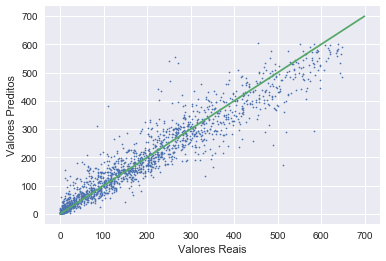

In [335]:
#visualize results
plt.plot(y_test, prev_RF2, linestyle='', marker='o', markersize=1.7)
plt.xlabel("Valores Reais")
plt.ylabel("Valores Preditos")
a=0
b=700
c = range(a,b)
plt.plot(c,c)
plt.show()

In [336]:
feature_importance_RF2 = reg_RF2.feature_importances_
cabeçalho = list(X.columns)
FI_RF2 = pd.DataFrame({'1 - Variáveis':cabeçalho, '2 - Importância': feature_importance_RF2})
FI_RF2 = FI_RF2.sort_values(by=['2 - Importância'],ascending=False)
FI_RF2

,1 - Variáveis,2 - Importância
36,demanda,0.416603
1,temp,0.124140
2,humidity,0.082040
11,cat_year,0.073913
7,cat_season_Inverno,0.043630
0,workingday,0.024903
21,cat_hour_9,0.023029
32,cat_hour_20,0.021875
3,windspeed,0.019586
20,cat_hour_8,0.016827


Os resultados da Floresta Aleatória, já partem de um patamar muito parecido ao da árvore de decisão otimizada, alcançamos um R² de 0,85. Ao analizar o gráfico de resíduos, vemos um comportamento novamente mais coeso e menos "escalar" como o das árvores de decisão. Como melhor modelo, vemos que os dados se interpolam através da linha ótima de melhor maneira.

Após o Grid Search, o modelo se adequa com 30 variáveis, e o R² dispara a 0,911. Um excelente resultado.

Tempo de execução do GridSearch: Apróximadamente 50min.

## 2.4 Gradient Boosting

Tentaremos aqui, o ajuste através de outro método conjunto, o Gradient Boosting regressor.

In [329]:
# Definição das variáveis e divisão entre teste e treinamento.
y = dataset['count'] #Variável resposta
X = dataset.drop(['season','holiday', 'weather', 'count', 'hour', 'day', 
                  'month', 'year','chuva?','Dimension 1','cat_weather_Névoa/Chuva Forte',
                 ], axis=1) #Variáveis a serem removidas do dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# vamos ver como a gente se sai usando um Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

# n_estimator é o número de árvores na floresta
gbr = GradientBoostingRegressor(n_estimators=1000)

# mesmo processo de sempre
gbr.fit(X_train, y_train)
prev_GB = gbr.predict(X_test)

score_GB = r2(y_test,prev_GB)
MAPE_GB = MAPE(y_test,prev_GB)
RMSLE_GB = rmsle(y_test,prev_GB)

print ("O coeficiente de determinação, R², do modelo é:", score_GB)
print ("O erro absoluto percentual médio do conjunto teste é (MAPE):", MAPE_GB)
print ("O RMSLE do conjunto teste é:", RMSLE_GB)


cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
cv_scores_GB = cross_val_score(gbr, X_test, y_test, cv=cv,scoring = 'r2')
cv_scores_RMSLE_GB = cross_val_score(gbr, X_test, y_test, cv=cv,scoring = scoring_function_RMSLE)

print ("O r² obtido através de cross validation score é:", np.mean(cv_scores_GB))
print ("O RMSLE obtido através de cross validation score é:", np.mean(cv_scores_RMSLE_GB))

C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p


O coeficiente de determinação, R², do modelo é: 0.9110640679047493
O erro absoluto percentual médio do conjunto teste é (MAPE): 63.71996173839707
O RMSLE do conjunto teste é: 0.5271038253123974


C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p
C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p
C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p
C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p


O r² obtido através de cross validation score é: 0.8810579223653413
O RMSLE obtido através de cross validation score é: 0.5904226604299162


C:\Users\totoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p


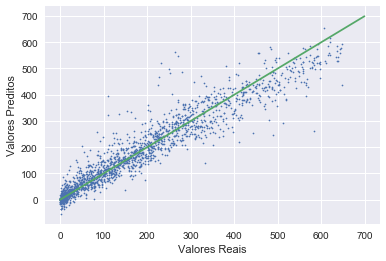

In [330]:
#visualize results
plt.plot(y_test, prev_GB, linestyle='', marker='o', markersize=1.7)
plt.xlabel("Valores Reais")
plt.ylabel("Valores Preditos")
a=0
b=700
c = range(a,b)
plt.plot(c,c)
plt.show()

In [331]:
feature_importance_GB = gbr.feature_importances_
cabeçalho = list(X.columns)
FI_GB = pd.DataFrame({'1 - Variáveis':cabeçalho, '2 - Importância': feature_importance_GB})
FI_GB = FI_GB.sort_values(by=['2 - Importância'],ascending=False)
FI_GB

,1 - Variáveis,2 - Importância
2,humidity,0.173582
1,temp,0.157560
11,cat_year,0.083416
0,workingday,0.081083
3,windspeed,0.073642
36,demanda,0.058188
5,cat_weather_Chuvoso,0.033769
7,cat_season_Inverno,0.029227
30,cat_hour_18,0.026216
29,cat_hour_17,0.022904


### 2.4.1 Grid Search para Otimizar o Gradient Boosting Regressor

In [337]:
def fit_model_GB(X, y):
    
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.metrics import make_scorer
    from sklearn.grid_search import GridSearchCV
    from sklearn.cross_validation import ShuffleSplit
    
    # Gerar conjuntos de validação-cruzada para o treinamento de dados
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 5, test_size = 0.20, random_state = 42)

    # Gerar Random Forest de regressão de objeto
    regressor = GradientBoostingRegressor()

    # Gerar um dicionário para os parâmetros do algoritmo
    params = [{'learning_rate': [0.1, 0.01], 
               'n_estimators': [350], 
               'max_depth':list(range(3,33,3))}] 
                    
    # Transformar 'performance_metric' em uma função de pontuação utilizando 'make_scorer' 
    scoring_fnc = make_scorer(r2)

    # Gerar o objeto de busca em matriz
    
    grid = GridSearchCV(regressor, params, scoring = scoring_fnc, cv = cv_sets)

    # Ajustar o objeto de busca em matriz com os dados para calcular o modelo ótimo
    grid = grid.fit(X, y)

    # Devolver o modelo ótimo depois de realizar o ajuste dos dados
    return grid.best_estimator_

In [338]:
# Ajustar os dados de treinamento para o modelo utilizando busca em matriz
reg_GB2 = fit_model_GB(X_train, y_train)

# Produzir valores para 'max_depth'
print ("O parâmetro 'max_depth' é",(reg_GB2.get_params()['max_depth']))
reg_GB2.get_params()

O parâmetro 'max_depth' é 6


{'alpha': 0.9,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 350,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}

In [339]:
prev_GB2 = reg_GB2.predict(X_test)

# Reportar a pontuação da previsão utilizando o conjunto de teste

score_GB2 = r2(y_test,prev_GB2)
print ("O coeficiente de determinação, R², do modelo, para o conjunto teste é {:.3f}.".format(score_GB2))

MAPE_GB2 = MAPE(y_test,prev_GB2)
print ("O erro absoluto percentual médio do conjunto teste é (MAPE):", MAPE_GB2)

RMSLE_GB2 = MAPE(y_test,prev_GB2)
print ("O RMSLE do conjunto teste é:", RMSLE_GB2)

O coeficiente de determinação, R², do modelo, para o conjunto teste é 0.908.
O erro absoluto percentual médio do conjunto teste é (MAPE): 48.42192595330079
O RMSLE do conjunto teste é: 48.42192595330079


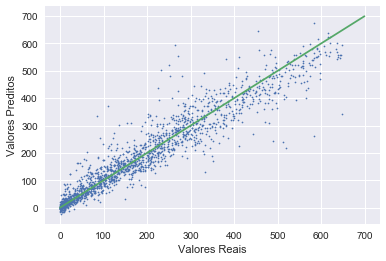

In [340]:
#visualize results
plt.plot(y_test, prev_GB2, linestyle='', marker='o', markersize=1.7)
plt.xlabel("Valores Reais")
plt.ylabel("Valores Preditos")
a=0
b=700
c = range(a,b)
plt.plot(c,c)
plt.show()

In [341]:
feature_importance_GB2 = reg_GB2.feature_importances_
cabeçalho = list(X.columns)
FI_GB2 = pd.DataFrame({'1 - Variáveis':cabeçalho, '2 - Importância': feature_importance_GB2})
FI_GB2 = FI_GB2.sort_values(by=['2 - Importância'],ascending=False)
FI_GB2

,1 - Variáveis,2 - Importância
2,humidity,0.198932
1,temp,0.182537
3,windspeed,0.118224
0,workingday,0.070012
11,cat_year,0.048954
36,demanda,0.040546
30,cat_hour_18,0.026486
9,cat_season_Primavera,0.024823
7,cat_season_Inverno,0.024447
29,cat_hour_17,0.020652


Após a calibragem ideal para o modelo, temos um resultado muito parecido com o obtido através do Random Forest (R² = 0,91). O R² foi de 0,908 contra 0,881 do modelo anterior. O fator que mais chamou atenção aqui, foi que pela primeira vez a demanda não o fator de maior importância para o modelo e a máxima pofundidade foi 6, um número bem menor que o 30 no random forest. Ainda assim os resultados foram bem próximos. A massa de dados do gráfico dos Resíduos serve como comparação neste caso.

Tempo de execução do GridSearch: Apróximadamente 1hr30min

## 3 - Comparação dos Resultados e Conclusão

Após executarmos alguns modelos, podemos ver a comparação de performance dos mesmos no gráfico abaixo.

In [342]:
b = {'Modelos':['Regressão Linear','Árvore de Decisão','Random Forest','Gradient Boosting'],
     'r2':[np.mean(cv_scores_RL2), score_DT2, score_RF2, score_GB2],'Origem':['teste','teste','teste','teste']}
Result = pd.DataFrame(data=b)
Result

,Modelos,Origem,r2
0,Regressão Linear,teste,0.773912
1,Árvore de Decisão,teste,0.841014
2,Random Forest,teste,0.911021
3,Gradient Boosting,teste,0.908384


Text(0.5,1,'Melhores pontuações (R²) por algoritmo')

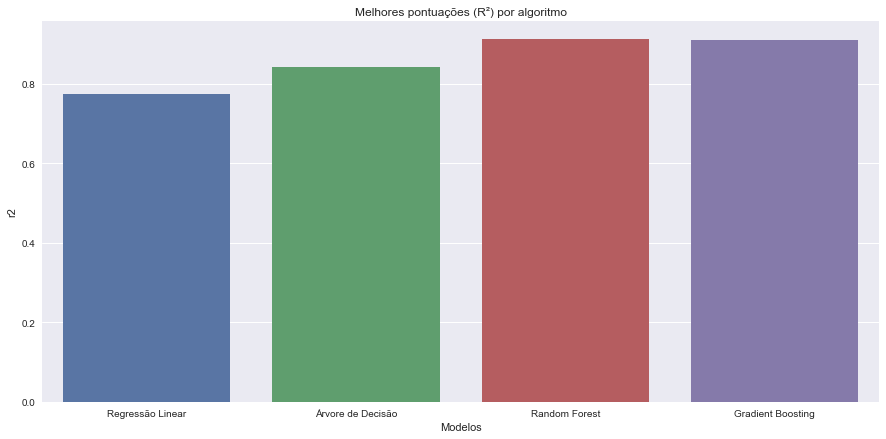

In [343]:
sns.set(style="darkgrid")
f, axes = plt.subplots(figsize=(15, 7), sharex=True)
sns.barplot(x="Modelos", y="r2", data=Result).set_title("Melhores pontuações (R²) por algoritmo")

Text(0.5,1,'Resíduos - Gradient Boosting')

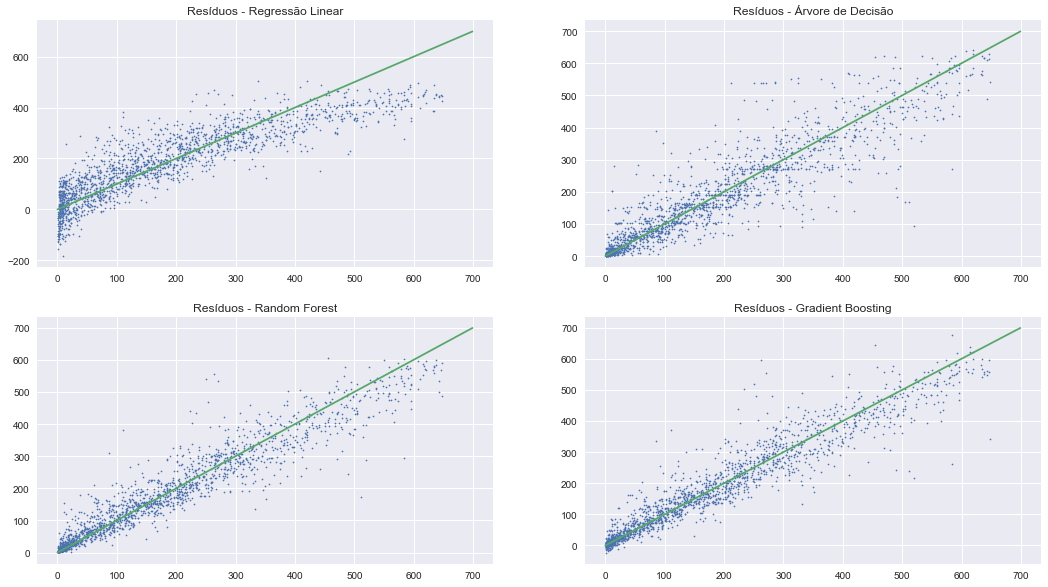

In [344]:
f, axes = plt.subplots(2, 2, figsize=(18, 10))
sns.despine(left=True)
a=0
b=700
c = range(a,b)
axes[0, 0].plot(y_test, predict_RL2, linestyle='', marker='o', markersize=1.7)
axes[0, 0].plot(c,c)
axes[0, 0].set_title('Resíduos - Regressão Linear')
axes[0, 1].plot(y_test, prev_DT2, linestyle='', marker='o', markersize=1.7)
axes[0, 1].plot(c,c)
axes[0, 1].set_title('Resíduos - Árvore de Decisão')
axes[1, 0].plot(y_test, prev_RF2, linestyle='', marker='o', markersize=1.7)
axes[1, 0].plot(c,c)
axes[1, 0].set_title('Resíduos - Random Forest')
axes[1, 1].plot(y_test, prev_GB2, linestyle='', marker='o', markersize=1.7)
axes[1, 1].plot(c,c)
axes[1, 1].set_title('Resíduos - Gradient Boosting')

Após analizarmos os resultados de todos os modelos utilizados, tivemos o algoritmo de Random Forest com o melhor desempenho, pelo critério do R², 0,911. Muito próximo disso, quase um empate técnico tivemos o Gradient Boosting com 0,908. Mais abaixo, árvore de decisão e a regressão linear completam o ranking, com R² de 0,84 e 0,77, respectivamente. 

Desde o primeiro modelo gerado, com R² de 0,66 até melhor com R² de 0,91, conseguimos uma boa evolução. A variável criada "Demanda" se mostroubastante eficiente para aumentar a capacidade explicativa do modelo. Infelizmente, a Dimensão criada pela PCA, não foi suficiente para substituir as variáveis que a deram origem, embora o decrescimento não tenha sido acentuado, em todas as vezes houve uma diminuição do R² quando feita a troca destas, nos modelos.

Interessante frisar o fato que o refinamento dos modelos, através do Grid Search, se mostrou eficiente em todas as tentativas, embora o tempo gasto para a execução dos mesmos tenha sido custoso. O Grid Search do Random forest, durou cerca de 50min e o Grid Search do Gradient Boosting durou cerca de 1:30hrs.

Em relação aos Resultados obtidos e a proposta de avaliação (R²), acredito ter alcançado uma boa aderência aos dados. Quando analisamos os gráficos dos resíduos, vemos os dados em torno da reta ideal, e isso é bom, princpalmente em valores até 200-300 alugueis/hora, onde temos uma massa de dados mais volumosa. Porém os algoritmos sofreram um pouco para aproximar valores quando o número de alugueis era muito elevado. Vemos que nestas circunstâncias a massa de dados se abre em torno da reta ideal, prejudicando o R². 

No geral, o algoritmo consegue generalizar, seguir a tendência e passar uma boa estimativa de demanda.